# Classifying Song Genres

In [ ]:
# This is a code cell without any tag. You can put convenience code here,
# but it won't be included in any way in the final project.
# For example, to be able to run tests locally in the notebook
# you need to install the following:
# pip install nose
# pip install git+https://github.com/datacamp/ipython_nose
# and then load in the ipython_nose extension like this:
%load_ext ipython_nose

Welcome to the official authoring notebook for your DataCamp Project! This notebook, named `project.ipynb`, contains a variety of tagged cells. Tags are in the top left corner of cells. Here's an example of a tag:

![tagged_cell_img](https://i.imgur.com/H2TB22Y.png)

These tagged cells are processed by software written by our talented DataCamp engineers and a [DataCamp Project](https://www.datacamp.com/projects) is the product.

<img src="https://i.imgur.com/7mqMP5E.jpg" alt="DataCamp Project interface" width="600px"/>

Before you start working on this notebook, please read the `project.ipynb` notebook format in our [documentation](https://authoring.datacamp.com/projects/projects-format.html). Each type of tagged cell is described there.

When you first open this notebook, you will find a template for each of the tagged cells for all tasks in your Project. Please abide by the content rules in both the documentation and in each template cell to ensure students have a consistent and smooth learning experience.

If you can't find an answer in the documentation or in this template, please [create an Issue](https://help.github.com/articles/creating-an-issue/) in your Project's GitHub repository and your DataCamp contact will respond as soon as possible.

Happy creating!

*Again, this cell won't be included in the live version of the Project because it has no tag.*

## 1. Preparing our dataset

_These recommendations are so on point! How does this playlist know me so well?_

Over the past few years, streaming services with vast catalogues have increasingly become the primary means through which most people listen to their favourite music. But at the same time, the wealth of options on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.

For this reason, streaming services have found various means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, decision trees and logistic regression.


To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist and number of listens. We have another dataset that has musical features of each track such as `danceability` and `acousticness` on a scale from -1 to 1. These exist in two different files, which are in different formats - csv and json. While csv is a popular file format for denoting tabular data, json is another common file format in which databases often return the results a given query.

Let's start by creating two pandas DataFrames out of these files that we can merge so we have labels and features for the classification later on.

**One** sentence that summarizes the code the student will write in this task.

- The specific task instructions go in a bullet point list. One sentence ideally (max 2) per bullet.
- Try to map code cell comments to instruction bullets.
- At most 4 bullets.

<hr>

## Good to know

The `@instructions` for **task 1** should include a "Good to know" section where you direct the student to resources that could be useful _throughout_ the Project, as well as the recommended prerequisites. You should also link to resources that are helpful for task 1 specifically. These resources could be external documentation, DataCamp courses and exercises, cheat sheets, Stack Overflow answers, etc. Recommended format for task 1 below.

This Project lets you practice the skills from [pandas Foundations](https://www.datacamp.com/courses/pandas-foundations) and [Manipulating DataFrames with pandas](https://www.datacamp.com/courses/manipulating-dataframes-with-pandas), including reading, exploring, filtering, and grouping data. We recommend that you take those courses before starting this Project.

Helpful links:
- pandas [cheat sheet](http://datacamp-community.s3.amazonaws.com/9f0f2ae1-8bd8-4302-a67b-e17f3059d9e8)
- pandas `read_csv()` function [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)
- Reading a flat file [exercise](https://campus.datacamp.com/courses/pandas-foundations/data-ingestion-inspection?ex=10) in the pandas Foundations course

Hints are meant for students who are stuck. Since students can't view solutions in Projects, clicking the hint button is their last resort. We often recommend including code scaffolding (example below).

You can read `path_to/my_data.csv` into a DataFrame named `my_data` like this after importing the pandas library:

```python
import pandas as pd
my_data = pd.read_csv("path_to/my_data.csv")
```

In [ ]:
# This is the sample code the student will see. It should
# consist of up to 10 lines of code and comments, and the
# student should have to complete at most 5 lines of code.

# Rule of thumb: each bullet point in @instructions should
# correspond to a comment in the @sample_code.

# Indicate missing code with ...
like_this = ...
# or when a line or more is required, like this:
# ... YOUR CODE FOR TASK 1 ...

In [4]:
# Import pandas
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
track_metrics = pd.read_json('datasets/echonest-clean.json', precise_float=True)

# Inspect data for null values
print(track_metrics.info())

# Merge the relevant columns of tracks and track_metrics
echo_tracks = pd.merge(track_metrics, tracks[['genre_top', 'track_id']], on='track_id')

# Inspect the resultant dataframe
echo_tracks.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 9999
Data columns (total 9 columns):
acousticness        13129 non-null float64
danceability        13129 non-null float64
energy              13129 non-null float64
instrumentalness    13129 non-null float64
liveness            13129 non-null float64
speechiness         13129 non-null float64
tempo               13129 non-null float64
track_id            13129 non-null int64
valence             13129 non-null float64
dtypes: float64(8), int64(1)
memory usage: 1.0 MB
None


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,track_id,valence,genre_top
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,2,0.576661,Hip-Hop
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,3,0.269240,Hip-Hop
2,0.977282,0.468808,0.134975,0.687700,0.105381,0.073124,119.646,341,0.430707,Rock
3,0.953349,0.498525,0.552503,0.924391,0.684914,0.028885,78.958,46204,0.430448,Rock
4,0.613229,0.500320,0.487992,0.936811,0.637750,0.030327,112.667,46205,0.824749,Rock


In [ ]:
# This needs to be included at the beginning of every @tests cell.
%%nose

# One or more tests of the students code.
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_example():
    assert like_this == 'missing part filled in', \
    'The student will see this message if the test fails'

## 2. Exploring pairwise relationships between continuous variables

We typically want to avoid using variables that have strong correlations with each other and hence avoid feature redundancy, for a few reasons:
- to keep the model simple and improve interpretability (with many features, we can start to overfit our data)
- when our datasets are very large, using fewer features can drastically speed up our computation time 

We will use simple builtin functions in the `pandas` and `seaborn` packages to get a sense of whether there are any strongly correlated features in our data.

**One** sentence that summarizes the code the student will write in this task.
- The specific task instructions go in a bullet point list. One sentence ideally (max 2) per bullet.
- Try to map code cell comments to instruction bullets.
- At most 4 bullets.

<hr>

Provide more info (if necessary) and include links to external resources under the horizontal ruler. The instructions should at most have 600 characters. Example format for links below.

Helpful links:
- pandas `read_csv()` function [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)
- Reading a flat file [exercise](https://campus.datacamp.com/courses/pandas-foundations/data-ingestion-inspection?ex=10) in the pandas Foundations course

Hints are meant for students who are stuck. Since students can't view solutions in Projects, clicking the hint button is their last resort. We often recommend including code scaffolding (example below).

You can read `path_to/my_data.csv` into a DataFrame named `my_data` like this after importing the pandas library:

```python
import pandas as pd
my_data = pd.read_csv("path_to/my_data.csv")
```

In [ ]:
# This is the sample code the student will see. It should
# consist of up to 10 lines of code and comments, and the
# student should have to complete at most 5 lines of code.

# Rule of thumb: each bullet point in @instructions should
# correspond to a comment in the @sample_code.

# Indicate missing code with ...
like_this = ...
# or when a line or more is required, like this:
# ... YOUR CODE FOR TASK 2 ...

/Users/Ahmed/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Ahmed/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


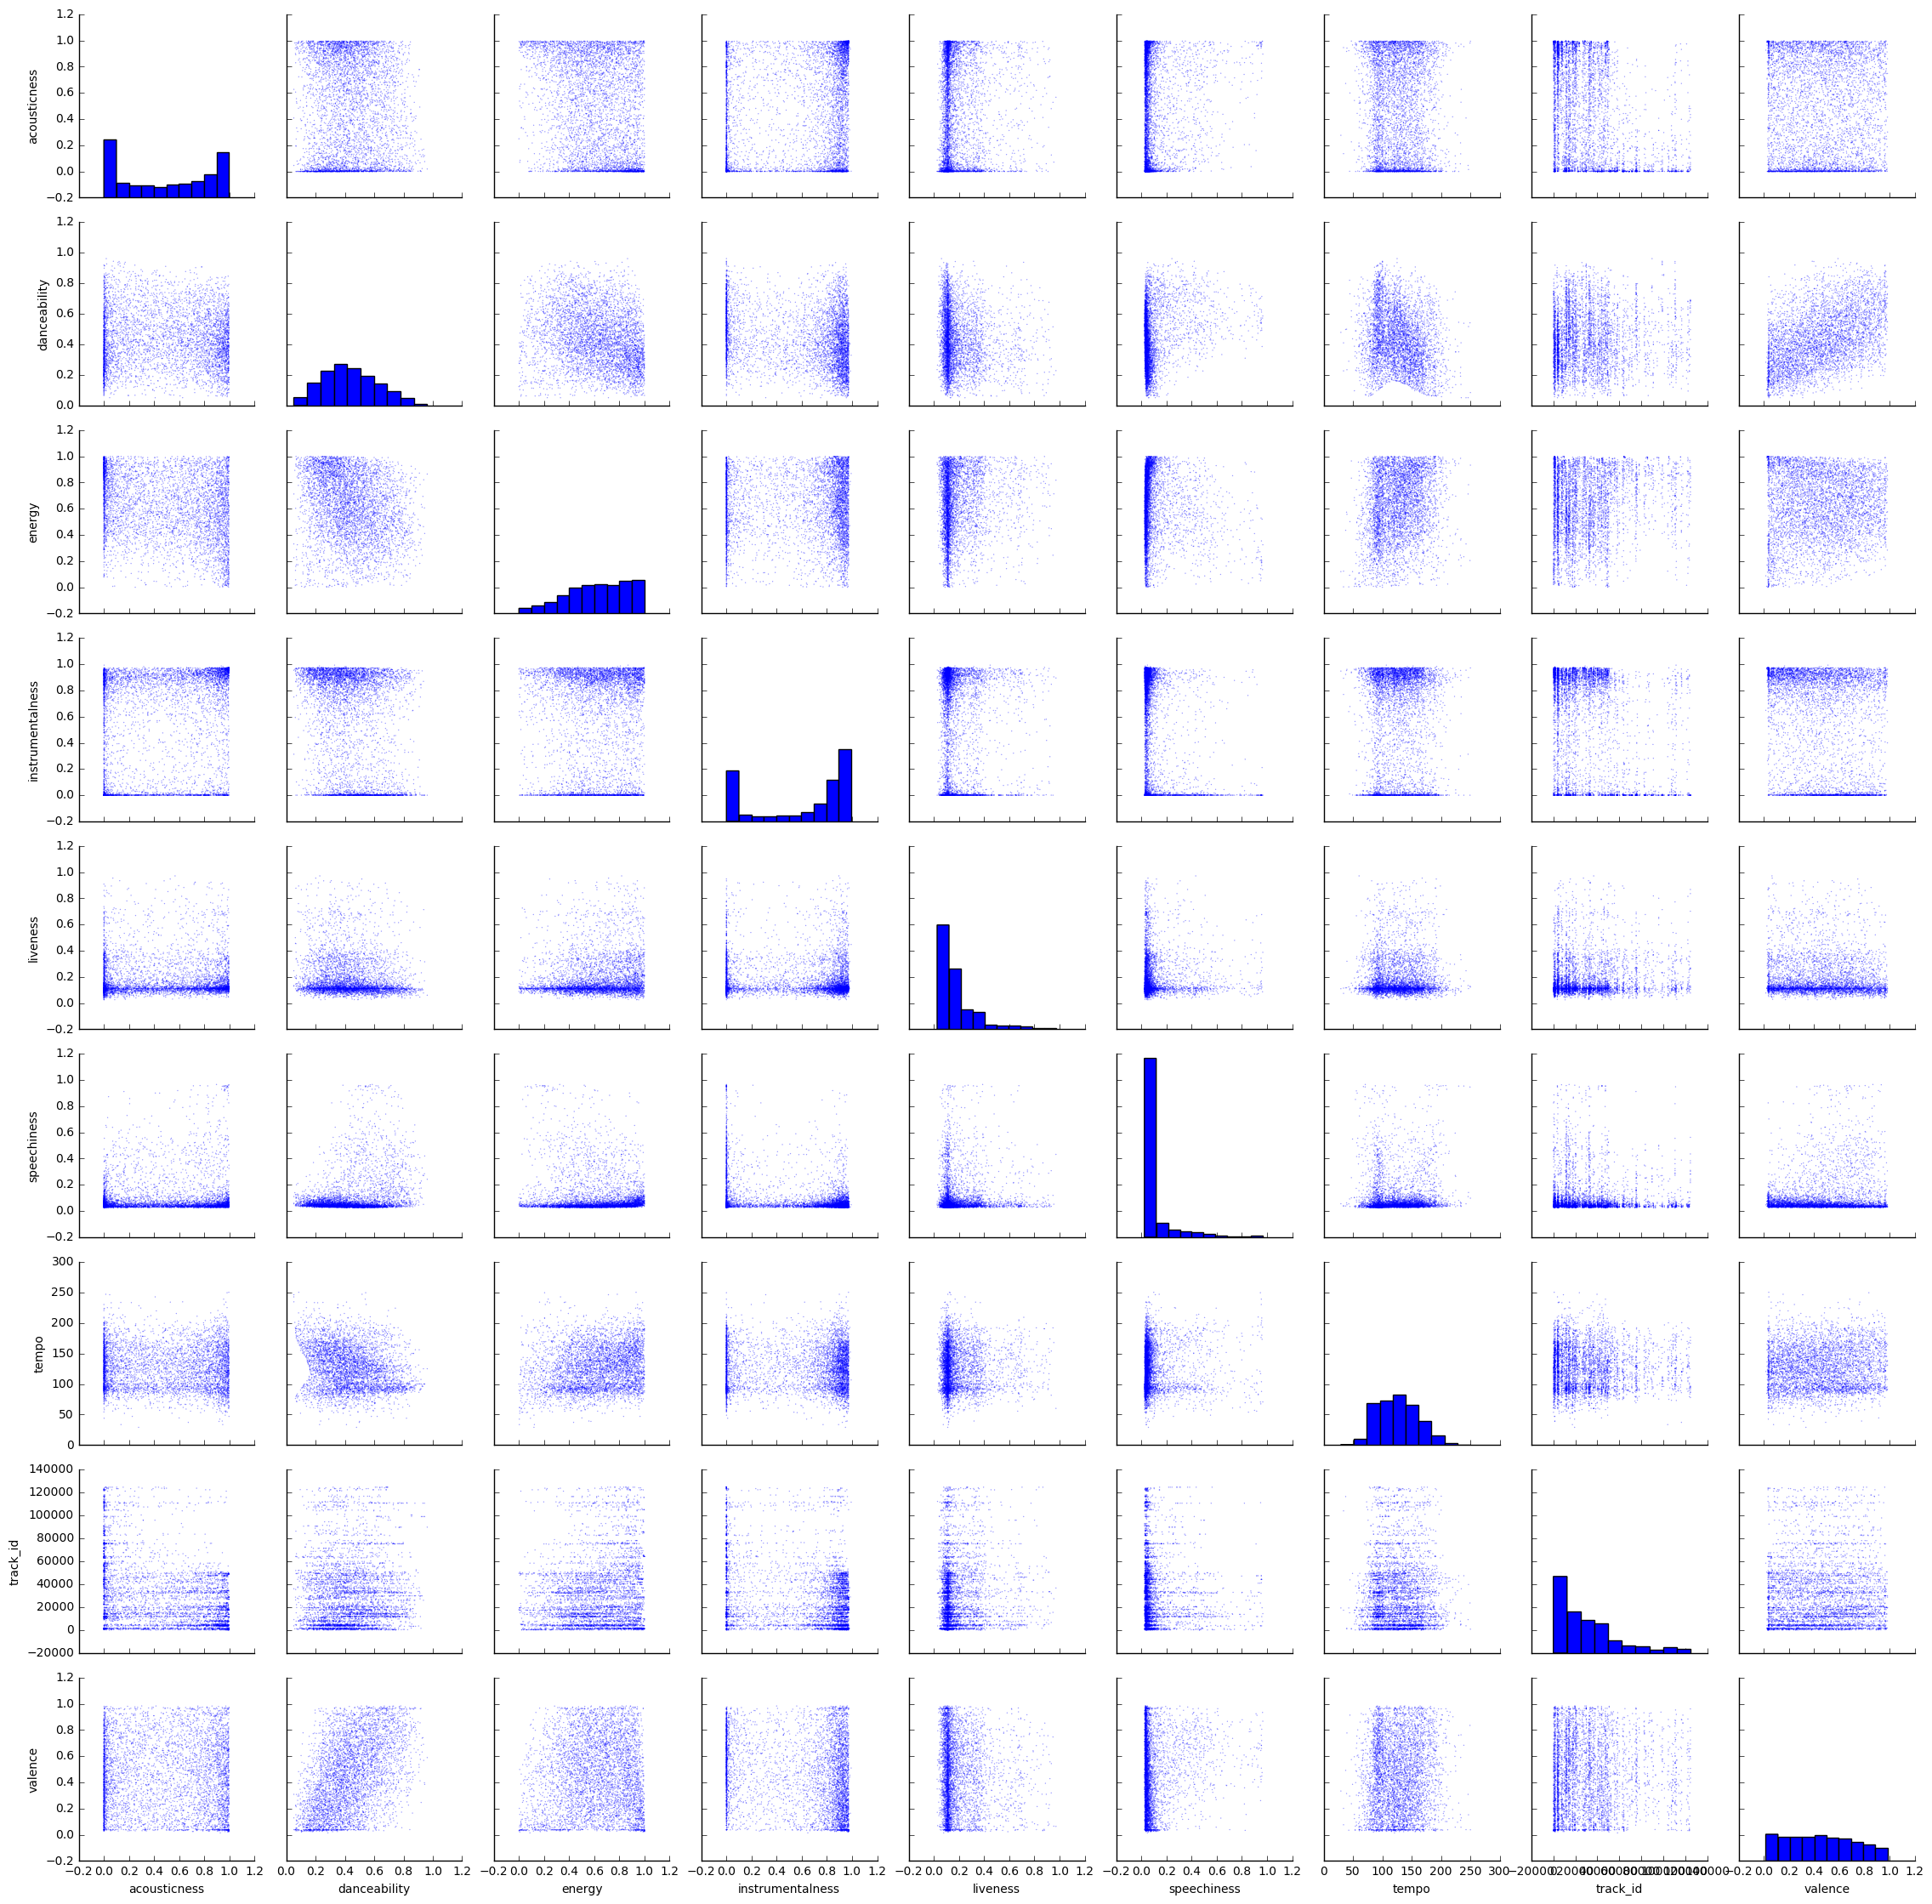

In [5]:
# Create a correlation matrix
track_metrics.corr().style.background_gradient()

# Turn on inline plotting
%matplotlib inline

# Import seaborn
import seaborn as sns

# Create the pairwise scatter plot
sns.pairplot(echo_tracks, plot_kws={'s':1, 'edgecolor':'none', 'alpha':0.4})

In [ ]:
# This needs to be included at the beginning of every @tests cell.
%%nose

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_example():
    assert like_this == 'missing part filled in', \
    'The student will see this message if the test fails'

## 3. Normalizing the feature data.

As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to acheive the best result. Since we didn't find any obviously strong correlations between our features, we can use a common approach to reduce the number of features called **principal component analysis (PCA)**. 

It is possible that the variance between genres can be explained by just a few features in the data set. PCA rotates the data along the axis of highest variance which we can make use of to determine the relative contribution of each feature of our data towards the variance between classes. 

However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through *standardization* such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).

**One** sentence that summarizes the code the student will write in this task.
- The specific task instructions go in a bullet point list. One sentence ideally (max 2) per bullet.
- Try to map code cell comments to instruction bullets.
- At most 4 bullets.

<hr>

Provide more info (if necessary) and include links to external resources under the horizontal ruler. The instructions should at most have 600 characters. Example format for links below.

Helpful links:
- pandas `read_csv()` function [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)
- Reading a flat file [exercise](https://campus.datacamp.com/courses/pandas-foundations/data-ingestion-inspection?ex=10) in the pandas Foundations course

Hints are meant for students who are stuck. Since students can't view solutions in Projects, clicking the hint button is their last resort. We often recommend including code scaffolding (example below).

You can read `path_to/my_data.csv` into a DataFrame named `my_data` like this after importing the pandas library:

```python
import pandas as pd
my_data = pd.read_csv("path_to/my_data.csv")
```

In [ ]:
# This is the sample code the student will see. It should
# consist of up to 10 lines of code and comments, and the
# student should have to complete at most 5 lines of code.

# Rule of thumb: each bullet point in @instructions should
# correspond to a comment in the @sample_code.

# Indicate missing code with ...
like_this = ...
# or when a line or more is required, like this:
# ... YOUR CODE FOR TASK 3 ...

In [6]:
# Separate your features and labels 
features = echo_tracks.drop(['genre_top', 'track_id'], axis=1) 
labels = echo_tracks['genre_top']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)


In [ ]:
# This needs to be included at the beginning of every @tests cell.
%%nose

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_example():
    assert like_this == 'missing part filled in', \
    'The student will see this message if the test fails'

## 4. Principle Component Analysis on our scaled data.

Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use **scree-plots** and **cumulative explained ratio plots** to find the number of components to use in further analyses.

Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.

**One** sentence that summarizes the code the student will write in this task.
- The specific task instructions go in a bullet point list. One sentence ideally (max 2) per bullet.
- Try to map code cell comments to instruction bullets.
- At most 4 bullets.

<hr>

Provide more info (if necessary) and include links to external resources under the horizontal ruler. The instructions should at most have 600 characters. Example format for links below.

Helpful links:
- pandas `read_csv()` function [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)
- Reading a flat file [exercise](https://campus.datacamp.com/courses/pandas-foundations/data-ingestion-inspection?ex=10) in the pandas Foundations course

Hints are meant for students who are stuck. Since students can't view solutions in Projects, clicking the hint button is their last resort. We often recommend including code scaffolding (example below).

You can read `path_to/my_data.csv` into a DataFrame named `my_data` like this after importing the pandas library:

```python
import pandas as pd
my_data = pd.read_csv("path_to/my_data.csv")
```

In [ ]:
# This is the sample code the student will see. It should
# consist of up to 10 lines of code and comments, and the
# student should have to complete at most 5 lines of code.

# Rule of thumb: each bullet point in @instructions should
# correspond to a comment in the @sample_code.

# Indicate missing code with ...
like_this = ...
# or when a line or more is required, like this:
# ... YOUR CODE FOR TASK 4 ...

<Container object of 8 artists>

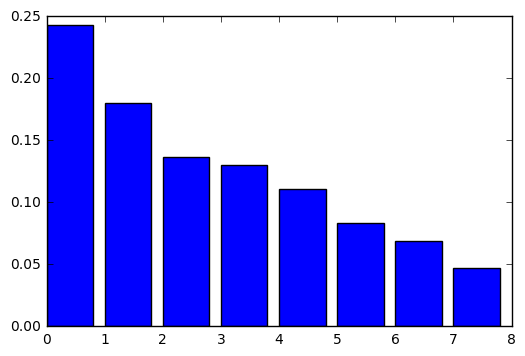

In [8]:
# Import our plotting module, and PCA function
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance
fig, ax = plt.subplots()
ax.bar(range(len(exp_variance)), exp_variance)

In [ ]:
# This needs to be included at the beginning of every @tests cell.
%%nose

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_example():
    assert like_this == 'missing part filled in', \
    'The student will see this message if the test fails'

## 5. Further visualization of PCA

Unfortunately, there does not appear to be a clear elbow in this scree plot, so it is not straightforward to find the number of intrinsic dimensions using this method. 

Instead, we can also look at the **cumulative explained variance plot** to determine how many features are required to explain about 90% of the variance. Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.

TODO: look for paper re: 90% cutoff

**One** sentence that summarizes the code the student will write in this task.
- The specific task instructions go in a bullet point list. One sentence ideally (max 2) per bullet.
- Try to map code cell comments to instruction bullets.
- At most 4 bullets.

<hr>

Provide more info (if necessary) and include links to external resources under the horizontal ruler. The instructions should at most have 600 characters. Example format for links below.

Helpful links:
- pandas `read_csv()` function [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)
- Reading a flat file [exercise](https://campus.datacamp.com/courses/pandas-foundations/data-ingestion-inspection?ex=10) in the pandas Foundations course

Hints are meant for students who are stuck. Since students can't view solutions in Projects, clicking the hint button is their last resort. We often recommend including code scaffolding (example below).

You can read `path_to/my_data.csv` into a DataFrame named `my_data` like this after importing the pandas library:

```python
import pandas as pd
my_data = pd.read_csv("path_to/my_data.csv")
```

In [ ]:
# This is the sample code the student will see. It should
# consist of up to 10 lines of code and comments, and the
# student should have to complete at most 5 lines of code.

# Rule of thumb: each bullet point in @instructions should
# correspond to a comment in the @sample_code.

# Indicate missing code with ...
like_this = ...
# or when a line or more is required, like this:
# ... YOUR CODE FOR TASK 5 ...

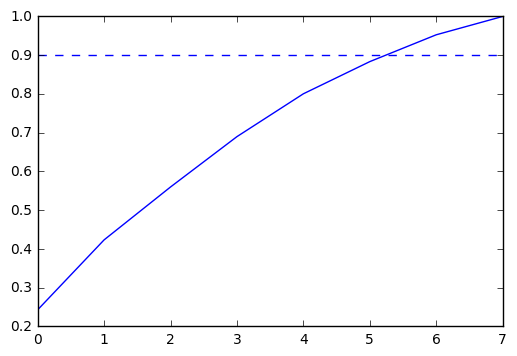

In [12]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')

# Use PCA with the chosen number of components
pca = PCA(6)
pca.fit(scaled_train_features)
projection = pca.transform(scaled_train_features)

In [ ]:
# This needs to be included at the beginning of every @tests cell.
%%nose

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_example():
    assert like_this == 'missing part filled in', \
    'The student will see this message if the test fails'

## 6. Train a decision tree to classify genre.

Now that we have reduced the dimensionality of our dataset, we can start classifying our data. In order to do that, we first need to split our dataset into 'train' and 'test' subsets, where the 'train' subset will be used to train our model while the 'test' dataset allows for model performance validation.

Here, we will be using a simple algorithm known as a decision tree. Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to use and interpret, decision trees allow us to visualize the 'logic flowchart' that the model generates from the training data.

**PICTURE**


**One** sentence that summarizes the code the student will write in this task.
- The specific task instructions go in a bullet point list. One sentence ideally (max 2) per bullet.
- Try to map code cell comments to instruction bullets.
- At most 4 bullets.

<hr>

Provide more info (if necessary) and include links to external resources under the horizontal ruler. The instructions should at most have 600 characters. Example format for links below.

Helpful links:
- pandas `read_csv()` function [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)
- Reading a flat file [exercise](https://campus.datacamp.com/courses/pandas-foundations/data-ingestion-inspection?ex=10) in the pandas Foundations course

Hints are meant for students who are stuck. Since students can't view solutions in Projects, clicking the hint button is their last resort. We often recommend including code scaffolding (example below).

You can read `path_to/my_data.csv` into a DataFrame named `my_data` like this after importing the pandas library:

```python
import pandas as pd
my_data = pd.read_csv("path_to/my_data.csv")
```

In [ ]:
# This is the sample code the student will see. It should
# consist of up to 10 lines of code and comments, and the
# student should have to complete at most 5 lines of code.

# Rule of thumb: each bullet point in @instructions should
# correspond to a comment in the @sample_code.

# Indicate missing code with ...
like_this = ...
# or when a line or more is required, like this:
# ... YOUR CODE FOR TASK 6 ...

In [18]:
# import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# split our data
train_features, test_features, train_labels, test_labels = train_test_split(
    projection, labels, random_state=10)

# train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

0.87094088259783509

In [ ]:
# This needs to be included at the beginning of every @tests cell.
%%nose

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_example():
    assert like_this == 'missing part filled in', \
    'The student will see this message if the test fails'

## 7. Compare our decision tree to a logistic regression.

- our tree does okay, but it's best to check its performance agsinst multiple other models and find the one that's best for our data
- describe logistic regression - 'test against the best simple model first' (Occam's razor!)

Although our tree's performance is decent, it's a bad idea to immediately assume that it's the right tool for the job -- maybe there are other models that will perform even better! It's always a worthwhile idea to at least test a few other algorithms and find the one that's best for our data.

Sometimes simplest is best, and so we will start by applying logistic regression. Logistic regression makes use of what's called the logistic function to calculate the odds that a given data point belongs to a given class. Once we have both models, we can compare them on a few performance metrics, such as false positive and false negative rate (how many points are inaccurately classified). 

**One** sentence that summarizes the code the student will write in this task.
- The specific task instructions go in a bullet point list. One sentence ideally (max 2) per bullet.
- Try to map code cell comments to instruction bullets.
- At most 4 bullets.

<hr>

Provide more info (if necessary) and include links to external resources under the horizontal ruler. The instructions should at most have 600 characters. Example format for links below.

Helpful links:
- pandas `read_csv()` function [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)
- Reading a flat file [exercise](https://campus.datacamp.com/courses/pandas-foundations/data-ingestion-inspection?ex=10) in the pandas Foundations course

Hints are meant for students who are stuck. Since students can't view solutions in Projects, clicking the hint button is their last resort. We often recommend including code scaffolding (example below).

You can read `path_to/my_data.csv` into a DataFrame named `my_data` like this after importing the pandas library:

```python
import pandas as pd
my_data = pd.read_csv("path_to/my_data.csv")
```

In [ ]:
# This is the sample code the student will see. It should
# consist of up to 10 lines of code and comments, and the
# student should have to complete at most 5 lines of code.

# Rule of thumb: each bullet point in @instructions should
# correspond to a comment in the @sample_code.

# Indicate missing code with ...
like_this = ...
# or when a line or more is required, like this:
# ... YOUR CODE FOR TASK 7 ...

In [19]:
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# compare the models
from sklearn.metrics import classification_report
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.66      0.66      0.66       229
       Rock       0.92      0.92      0.92       972

avg / total       0.87      0.87      0.87      1201

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.75      0.57      0.65       229
       Rock       0.90      0.95      0.93       972

avg / total       0.87      0.88      0.87      1201



In [ ]:
# This needs to be included at the beginning of every @tests cell.
%%nose

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_example():
    assert like_this == 'missing part filled in', \
    'The student will see this message if the test fails'

## 8. Balance our data for greater performance.

Both our models do similarly well, boasting 87% precision each. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip hop songs are disproportionately misclassified as rock songs. 

Why might this be the case? Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.

To account for this, we can balance our data such that the number of data points is equivalent in both classes.

**One** sentence that summarizes the code the student will write in this task.
- The specific task instructions go in a bullet point list. One sentence ideally (max 2) per bullet.
- Try to map code cell comments to instruction bullets.
- At most 4 bullets.

<hr>

Provide more info (if necessary) and include links to external resources under the horizontal ruler. The instructions should at most have 600 characters. Example format for links below.

Helpful links:
- pandas `read_csv()` function [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)
- Reading a flat file [exercise](https://campus.datacamp.com/courses/pandas-foundations/data-ingestion-inspection?ex=10) in the pandas Foundations course

Hints are meant for students who are stuck. Since students can't view solutions in Projects, clicking the hint button is their last resort. We often recommend including code scaffolding (example below).

You can read `path_to/my_data.csv` into a DataFrame named `my_data` like this after importing the pandas library:

```python
import pandas as pd
my_data = pd.read_csv("path_to/my_data.csv")
```

In [ ]:
# This is the sample code the student will see. It should
# consist of up to 10 lines of code and comments, and the
# student should have to complete at most 5 lines of code.

# Rule of thumb: Each bullet point in @instructions should
# correspond to a comment in the @sample_code

# Indicate missing code with ...
like_this = ...
# or when a line or more is required, like this:
# ... YOUR CODE FOR TASK 8 ...

In [20]:
# Balance our data and redefine our features and labels
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock'].sample(hop_only.shape[0])
rock_hop_bal = pd.concat([rock_only, hop_only])

features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

scaled_train_features = scaler.fit_transform(features)


from sklearn.linear_model import LogisticRegression

pred_labels_logit = logreg.predict(test_features)
pred_labels_tree = tree.predict(test_features)

from sklearn.metrics import classification_report
print("Decision Tree: \n", classification_report(scaled_train_features, pred_labels_tree))
print("Logistic Regression: \n", classification_report(scaled_train_features, pred_labels_logit))

In [ ]:
# This needs to be included at the beginning of every @tests cell.
%%nose

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_example():
    assert like_this == 'missing part filled in', \
    'The student will see this message if the test fails'

## 9. Using cross-validation to evaluate our models.

Now that we've trained our model on balanced data, the final step is to apply what's called **cross-validation** (CV). This step allows us to compare models in a more rigorous fashion.

Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use K-fold CV. K-fold splits the data in K different, equally sized subsets. K-fold iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we aggregate the results from each fold for a final model performance score.

**One** sentence that summarizes the code the student will write in this task.
- The specific task instructions go in a bullet point list. One sentence ideally (max 2) per bullet.
- Try to map code cell comments to instruction bullets.
- At most 4 bullets.

<hr>

Provide more info (if necessary) and include links to external resources under the horizontal ruler. The instructions should at most have 600 characters. Example format for links below.

Helpful links:
- pandas `read_csv()` function [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)
- Reading a flat file [exercise](https://campus.datacamp.com/courses/pandas-foundations/data-ingestion-inspection?ex=10) in the pandas Foundations course

Hints are meant for students who are stuck. Since students can't view solutions in Projects, clicking the hint button is their last resort. We often recommend including code scaffolding (example below).

You can read `path_to/my_data.csv` into a DataFrame named `my_data` like this after importing the pandas library:

```python
import pandas as pd
my_data = pd.read_csv("path_to/my_data.csv")
```

In [ ]:
# This is the sample code the student will see. It should
# consist of up to 10 lines of code and comments, and the
# student should have to complete at most 5 lines of code.

# Rule of thumb: Each bullet point in @instructions should
# correspond to a comment in the @sample_code

# Indicate missing code with ...
like_this = ...
# or when a line or more is required, like this:
# ... YOUR CODE FOR TASK 8 ...

In [24]:
# Set up our K-fold cross-validation
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(5, random_state=10)

# Set up our models again
tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)


tree_score = cross_val_score(tree, scaled_train_features, labels, cv=kf)
logit_score = cross_val_score(logreg, scaled_train_features, labels, cv=kf)

print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.776373626374 Logistic Regression: 0.777472527473


In [ ]:
# This needs to be included at the beginning of every @tests cell.
%%nose

# One or more tests of the students code. 
# The @solution should pass the tests.
# The purpose of the tests is to try to catch common errors and to 
# give the student a hint on how to resolve these errors.

def test_example():
    assert like_this == 'missing part filled in', \
    'The student will see this message if the test fails'

*The recommended number of tasks in a DataCamp Project is between 8 and 10, so feel free to add more if necessary. You can't have more than 12 tasks.*

*The recommended number of tasks in a DataCamp Project is between 8 and 10, so feel free to add more if necessary. You can't have more than 12 tasks.*